# <font color=#2e86c1> $R_{1\rho}$ simulation and analysis</font> 

<a href="https://githubtocolab.com/alsinmr/ConferenceExamples/blob/master/JupyterBook/ssNMR2025/R1p.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

The $R_{1\rho}$ experiment is a useful experiment for characterizing slow ($\mu$s/ms) motion in solid-state NMR. The pulse sequence involves flipping magnetization of a spin (often $^{15}$N or $^{13}$C, CP-based excitation also possible) to the x-axis, spin-locking that magnetization, and observing its decay (again, CP-transfer back to $^1$H may be useful).

<img src="R1p_sequence.png" alt="sequence" width=300>

This experiment is sensitive to both reorientational motion of anisotropic tensors (dipole/CSA) and changes to the isotropic chemical shift. In the first part of this exercise, we will use simulation to explore the relaxation behavior of the $R_{1\rho}$ experiment, and in the second part, we will fit $R_{1\rho}$ measurements to extract dynamics parameters from a data set.

## Part 1: Simulating $R_{1\rho}$
Relaxation can be simulated by creating a spin system that exchanges between two states stochastically, thereby inducing various relaxation processes. For $R_{1\rho}$, we simply need to use such a system with a spin-lock on one of the spins. Below, we set up the SLEEPY code for a basic $R_{1\rho}$ experiment.

### Python Setup
If SLEEPY is not already installed (e.g. if working in Google Colab), then we need to install it. We then need to import the SLEEPY module, as well as numpy which has a lot of linear algebra and other mathematical tools, and matplotlib, which is used to create figures. We also turn off messages from SLEEPY.

In [1]:
# Make sure SLEEPY is installed and on the path
import sys
import os
sys.path.append('/Users/albertsmith/Documents/GitHub/')

In [2]:
import sys
if 'google.colab' in sys.modules: #Colab
    !pip install sleepy-nmr
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt
sl.Defaults['verbose']=False

### Simulation Setup
Setup contains similar parameters as SIMPSON, with an important distinction: we set up the system
twice (ex0,ex1) with different Euler angles, to introduce reorientational motion, and with a different chemical shift, to introduce chemical exchange.

Reorientational motion is introduced by putting a dipole and/or CSA into both ex0 and ex1, with the same coupling size, but with a different set of Euler angles (usually introduced on the beta angle). Here, we use both the dipole and CSA as would be typical for $^{15}$N in the protein backbone.

Chemical exchange is introduced by including a chemical shift that changes value between ex0 and ex1.

Note that this setup means reorientation and chemical exchange are simultaneous processes.

#### Parameters

In [3]:
# H-N dipole coupling for 0.102 nm
# Note, this value is the dipole anisotropy,
# which is twice the size of the coupling given in SIMPSON
deltaHN=sl.Tools.dipole_coupling(.102,'1H','15N')
# Typical protein backbone 15N CSA
deltaCSA=113
# Change in the 15N chemical shift
DelCS=10
# Hop angle
hop_angle=25
# Correlation time of the exchange
tc=1e-5
# Population of state 1
p1=0.5
# Spin-lock strength
v1=35000

#### Build the experimental systems

In [4]:
# Magnetic field (MHz), Nuclei, spinning rate, powder-average quality
ex0=sl.ExpSys(v0H=600,Nucs=['15N','1H'],vr=60000,pwdavg=2,n_gamma=30)
# H–N dipole coupling, i0: spin 0, i1: spin 1, delta: anisotropy of interaction
ex0.set_inter('dipole',i0=0,i1=1,delta=deltaHN)
# 15N CSA, i: spin, delta: anisotropy in ppm, euler_d: Euler angles in degrees
ex0.set_inter('CSA',i=0,delta=deltaCSA,euler_d=[0,23,120])
# 15N chemical shift, i: spin, CS: chemical shift in ppm
ex0.set_inter('CS',i=0,ppm=DelCS/2)

# Copy ex0 (links copies, ensures matching experimental settings)
ex1=ex0.copy()
# As above, plus tilt the dipole coupling by the hop_angle
ex1.set_inter('dipole',i0=0,i1=1,delta=deltaHN,euler_d=[0,hop_angle,0])
# As above, plus add a second set of Euler angles with the hop angle
ex1.set_inter('CSA',i=0,delta=deltaCSA,euler_d=[[0,23,120],[0,hop_angle,0]])
# As above, but change CS
_=ex1.set_inter('CS',i=0,ppm=-DelCS/2)  # _ captures the output, reducing clutter

#### Couple systems into a Liouvillian, generate a pulse sequence

In [5]:
# Create a Liouvillian with two systems in exchange
L=sl.Liouvillian(ex0,ex1)
# Add an exchange matrix betweent the two systems
L.kex=sl.Tools.twoSite_kex(tc=tc,p1=p1)

# Create a pulse sequence object
seq=L.Sequence()
# Add a spin-locking field 
# For continuous field, we can just specify power
# but including a time axis with varying power, phase, and offset is also possible
_=seq.add_channel('15N',v1=v1)
# Note that the default sequence length is 1 rotor period if the time axis is not given

#### Create a density matrix, propagate

In [6]:
# Initial state of density matrix, detection matrix
rho=sl.Rho(rho0=ex0.Op[0].x@ex0.Op[1].beta,detect='15Nx')
# Propagate for 100 ms (n is number of steps, use int() to get an integer)
_=rho.DetProp(seq,n=int(0.1*ex0.vr)) 

### Plot the results

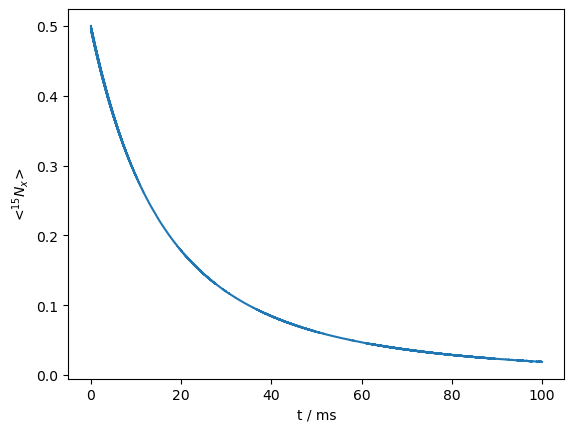

In [7]:
_=rho.plot()

### Create functions for faster setup
If we want to repeat calculations under varying conditions, it can be easier to wrap the setup up in a function, and then we can just call that function later. Two functions are generated here:

* R1pU : Propagator for 1 rotor period. Optionally adjust correlation time (tc, s), populations (p1), hop angle (hop_angle, degrees), size of chemical exchange (DelCS, ppm), applied field strength (v1, Hz).

* R1p_rho : Density matrix, propagated for 100 ms. Same arguments as R1pU.

There's not much new in terms of SLEEPY in the code below. Skip over, or read more carefully if you're interested in how to setup a function in Python.

In [8]:
def R1pU(tc=tc,p1=p1,hop_angle=hop_angle,DelCS=DelCS,v1=v1,gamma=120):
    ex0=sl.ExpSys(v0H=600,Nucs=['15N','1H'],vr=60000,pwdavg=2,n_gamma=30)
    ex0.set_inter('dipole',i0=0,i1=1,delta=deltaHN,euler_d=[0,-hop_angle/2,0])
    ex0.set_inter('CSA',i=0,delta=deltaCSA,euler_d=[[0,23,gamma],[0,-hop_angle/2,0]])
    ex0.set_inter('CS',i=0,ppm=DelCS/2)
    
    ex1=ex0.copy()
    ex1.set_inter('dipole',i0=0,i1=1,delta=deltaHN,euler_d=[0,hop_angle/2,0])
    ex1.set_inter('CSA',i=0,delta=deltaCSA,euler_d=[[0,23,gamma],[0,hop_angle/2,0]])
    ex1.set_inter('CS',i=0,ppm=-DelCS/2)

    L=sl.Liouvillian(ex0,ex1)
    L.kex=sl.Tools.twoSite_kex(tc=tc,p1=p1)
    
    seq=L.Sequence()
    seq.add_channel('15N',v1=v1)
    return seq.U()

def R1p_rho(tc=tc,p1=p1,hop_angle=hop_angle,DelCS=DelCS,v1=v1):
    U=R1pU(tc=tc,p1=p1,hop_angle=hop_angle,DelCS=DelCS,v1=v1)
    rho=sl.Rho(rho0='15Nx',detect='15Nx')
    rho.DetProp(U**int(U.expsys.vr/1000),n=100)
    return rho

### Examine relaxation for various conditions

1. High spin-lock strength (35 kHz)

   We'll first calculate relaxation with both reorientational dynamics and chemical exchange. Then, we'll calculate each process separately to see which dominates the relaxation at this field strength. 

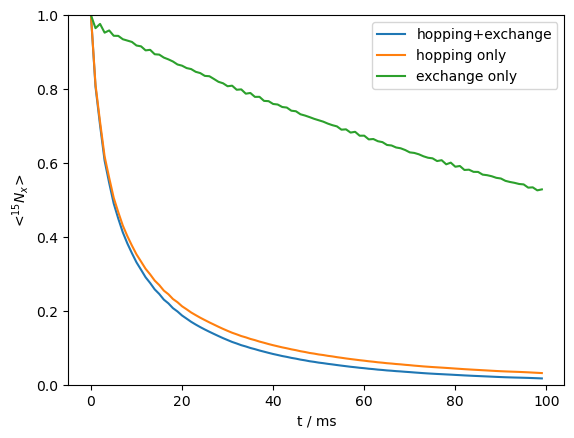

In [9]:
v1=35000
rho=R1p_rho(v1=v1)
rho_hop=R1p_rho(v1=v1,DelCS=0) #Sets the chemical exchange to 0
rho_ex=R1p_rho(v1=v1,hop_angle=0) #Sets the reorientational motion to 0

ax=rho.plot(label='hopping+exchange')   #plot returns an axis, which we can use for the subsequent plots
rho_hop.plot(ax=ax,label='hopping only') #Now use ax as an argument
rho_ex.plot(ax=ax,label='exchange only')

ax.set_ylim([0,1])  #Make the axis go down to 0
ax.legend()  #Show a legend with the labels given above

At 35 kHz, what is the dominant relaxation process, reorientational dynamics, or chemical exchange?
```{dropdown} Answer
Relaxation due to reorientation is much faster, where removing exchange has only a minor impact on the relaxation curve.
```

2. Low spin-lock strength (4 kHz)

   We repeat the above calculation, but with only 4 kHz spin-lock.

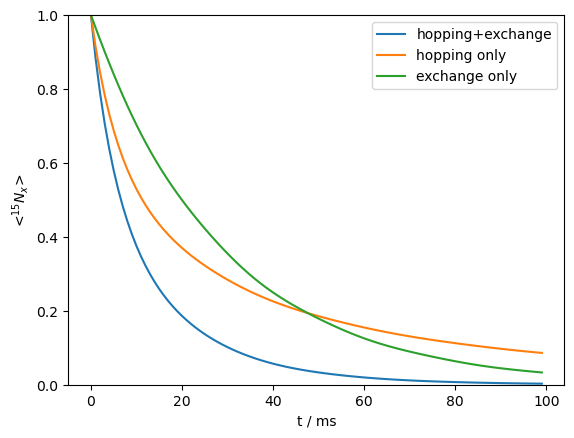

In [10]:
v1=4000
rho=R1p_rho(v1=v1)
rho_hop=R1p_rho(v1=v1,DelCS=0) #Sets the chemical exchange to 0
rho_ex=R1p_rho(v1=v1,hop_angle=0) #Sets the reorientational motion to 0

ax=rho.plot(label='hopping+exchange')   #plot returns an axis, which we can use for the subsequent plots
rho_hop.plot(ax=ax,label='hopping only') #Now use ax as an argument
rho_ex.plot(ax=ax,label='exchange only')

ax.set_ylim([0,1])  #Make the axis go down to 0
ax.legend()  #Show a legend with the labels given above

Compare the curves for hopping only and exchange only. Why do the curves cross?
```{dropdown} Answer
The initial decay from hopping is faster, but by the end of the plot, more decay has occurred for exchange. The curves cross because the exchange process yields a monoexponentially decaying signal, whereas the hopping process yields multiexponential decay.
```

#### Sources of multiexpontiality

Above, we noticed that hopping yields multiexponential decay. Give one reason for the multiexponential decay (there are actually two sources, but we start with the one that is more obvious to me)
```{dropdown} Answer
The first reason is that different elements of the powder average relax with different rate constants. SLEEPY lets us plot individual elements of the powder average, so let's check if relaxation becomes monoexponential! (reveal hidden cell below)
```

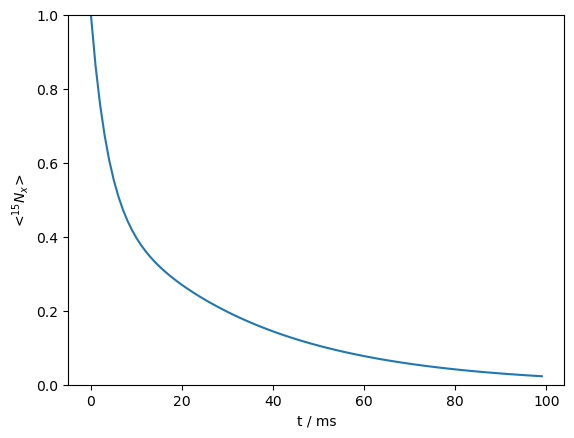

In [11]:
pwd_index=5
ax=rho_hop.plot(pwd_index=pwd_index)     #pwd_index specifies which element of the powder element to display
_=ax.set_ylim([0,1]) #Adjust the y-axis

So, the curve is still bi-exponential. Then, what is the second reason for multi-exponentiality?
*Hint: What interactions undergo reorientational motion?*
```{dropdown}Answer
Both the CSA and dipole coupling are undergoing reorientational dynamics. Then, depending if the $^1$H is spin-up or spin-down, the CSA/dipole relaxation will be additive or subtractive, yielding different relaxation rates. Reveal the cell below, where we separate the $^1$H spin-up (alpha) and spin-down (beta) states.
```

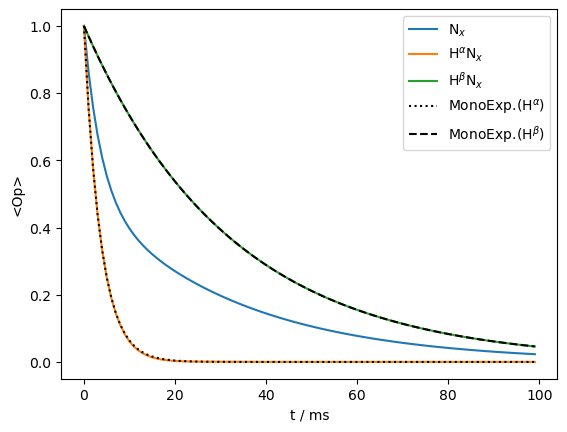

In [12]:
#ex0.Op are the spin-operator matrices.
#Index for the desired spin and then get x,y,z,p(+),m(-),alpha, or beta matrices
#Use the @ symbol for matrix multiplication
HalphaNx=ex0.Op[0].x@ex0.Op[1].alpha
HbetaNx=ex0.Op[0].x@ex0.Op[1].beta
U=R1pU(v1=v1,DelCS=0)
rho=sl.Rho(rho0='15Nx',detect=['15Nx',HalphaNx,HbetaNx])

# Here we extract the decay rates (A little tricky)
# We need to grab the right element of the powder average ([pwd_avg]),
# which then still has a very fast decaying, but low weighted term
# and a slow decay term, which is the relevant one (.min())
rates,*_=rho.clear().extract_decay_rates(U,det_num=1,mode='rates')
Ralpha=rates[pwd_index].min()
rates,*_=rho.clear().extract_decay_rates(U,det_num=2,mode='rates')
Rbeta=rates[pwd_index].min()

rho.DetProp(U**60,n=100)
ax=rho.plot(pwd_index=5,det_num=0,label=r'N$_x$')
rho.plot(pwd_index=5,det_num=1,label=r'H$^\alpha$N$_x$',ax=ax)
rho.plot(pwd_index=5,det_num=2,label=r'H$^\beta$N$_x$',ax=ax)

ax.plot(rho.t_axis*1e3,np.exp(-rho.t_axis*Ralpha),linestyle=':',color='black',label=r'MonoExp.(H$^\alpha$)')
ax.plot(rho.t_axis*1e3,np.exp(-rho.t_axis*Rbeta),linestyle='--',color='black',label=r'MonoExp.(H$^\beta$)')

_=ax.legend()

Then, we see that for a single orientation, and single state of the $^1$H, we do indeed get monoexponential relaxation. Note that if the $^1$H inverts due to $T_1$ or spin-diffusion, the multi-exponential behavior will be reduced. See below, where we invert the $^1$H 100 times per second (stochastic motion).

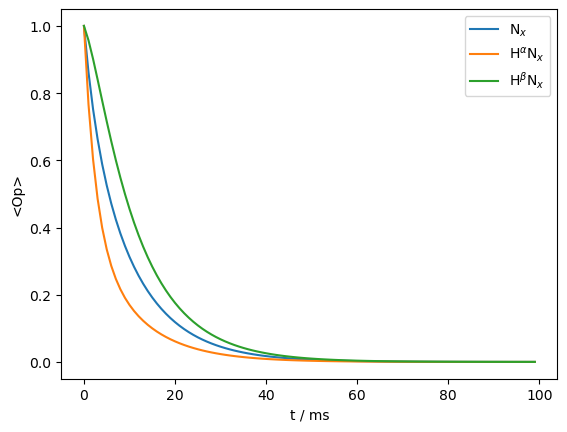

In [13]:
U=R1pU(v1=v1,DelCS=0)
# Caution below: editing the Liouvillian post propagator creation
# is only supported if the propagator is not cached yet
U.L.add_relax('SpinDiffusion',i=1,k=100)  #Adds 1H inversion
rho=sl.Rho(rho0='15Nx',detect=['15Nx',HalphaNx,HbetaNx])

rho.DetProp(U**60,n=100)
ax=rho.plot(pwd_index=5,det_num=0,label=r'N$_x$')
rho.plot(pwd_index=5,det_num=1,label=r'H$^\alpha$N$_x$',ax=ax)
rho.plot(pwd_index=5,det_num=2,label=r'H$^\beta$N$_x$',ax=ax)

_=ax.legend()

## Bonus: Edit the following code to simulate T$_1$ relaxation instead of T$_{1\rho}$
*Hints:*


In [ ]:
ex0=sl.ExpSys(v0H=600,Nucs=['15N','1H'],vr=60000,pwdavg=2,n_gamma=30)
ex0.set_inter('dipole',i0=0,i1=1,delta=deltaHN)
ex0.set_inter('CSA',i=0,delta=deltaCSA,euler_d=[0,23,120])

ex1=ex0.copy()
ex1.set_inter('dipole',i0=0,i1=1,delta=deltaHN,euler_d=[0,hop_angle,0])
ex1.set_inter('CSA',i=0,delta=deltaCSA,euler_d=[[0,23,120],[0,hop_angle,0]])

L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(tc=tc,p1=p1)

seq=L.Sequence()
_=seq.add_channel('15N',v1=v1)

# Initial state of density matrix, detection matrix
rho=sl.Rho(rho0=ex0.Op[0].x@ex0.Op[1].beta,detect='15Nx')
# Propagate for 100 ms (n is number of steps, use int() to get an integer)
_=rho.DetProp(seq,n=int(0.1*ex0.vr)) 

### Formulas for relaxation behavior
The relaxation that was simulated above can be calculated using formulas. For reorientational motion, we typically calculate the orientationally-averaged relaxation rate constant. For exchange, there is no orientation dependence, so the formula simply returns the relaxation rate constant.

Miloushev and Palmer$^1$ provide us with the relevant formula for predicting $R_{1\rho}$ relaxation due to chemical exchange.

$$
\begin{equation}
R_{1\rho}^{ex}=\frac{\sin^2\beta_ep_1p_2\Delta\omega_{12}^2k_{ex}}{\frac{\omega_{e1}^2\omega_{e2}^2}{\omega_e^2}+k_{ex}^2-\sin^2\beta_ep_1p_2\Delta\omega_{12}^2\left(1+\frac{2k_{ex}^2(p_1\omega_{e1}^2+p_2\omega_{e2}^2)}{\omega_{e1}^2\omega_{e2}^2+\omega_e^2k_{ex}^2}\right)}
\end{equation}
$$

with the following definitions:

$$
\begin{eqnarray}
k_{ex}&=&k_{1\rightarrow2}+k_{2\rightarrow1} \\
\Omega&=&p_1\Omega_1+p_2\Omega_2 \\
\Delta\omega_{12}&=&\Omega_1-\Omega_2 \\
\omega_e^2&=&\omega_1^2+\Omega^2 \\
\omega_{e1}^2&=&\omega_1^2+\Omega_1^2 \\
\omega_{e2}^2&=&\omega_1^2+\Omega_2^2 \\
\sin^2\beta_e&=&\frac{\omega_1^2}{\omega_1^2+\Omega^2}
\end{eqnarray}
$$

Kurbanov et al.$^2$ provide the formula for the orientationally-averaged $R_{1\rho}$ relaxation rate due to reorientational motion of a dipolar coupling and chemical shift anisotropy.

$$
\begin{eqnarray}
R_1&=&\left(\frac{\delta_{IS}}4\right)^2\left(J(\omega_I-\omega_S)+3J(\omega_I)+6J(\omega_I+\omega_S)\right)+\frac13(\omega_I\Delta\sigma)^2J(\omega_I) \\
R_{1\rho}&=&\frac12R_1+\left(\frac{\delta_{IS}}4\right)^2\left(3J(\omega_S)+\frac13J(\omega_1-2\omega_r)+\frac23J(\omega_1-\omega_r)+\frac23J(\omega_1+\omega_r)+\frac13J(\omega+2\omega_r)\right) \\
&+&\frac2{27}(\omega_I\Delta\sigma)^2\left(\frac12J(\omega_1-2\omega_r)+J(\omega_1-\omega_r)+J(\omega_1+\omega_r)+\frac12J(\omega_1+2\omega_r)\right)
\end{eqnarray}
$$

For a single correlation time and two-site hopping motion, the spectral density becomes

$$
\begin{equation}
J(\omega)=\frac25(1-S^2)\frac{\tau_c}{1+(\omega\tau_c)^2}
\end{equation}
$$

with $S^2=1+3p_1p_2(\cos^2{(\theta)}-1)$, where $\theta$ is the hop angle, and $\tau_c=1/(k_{1\rightarrow2}+k_{2\rightarrow1})$

[1] V.Z. Miloushev, A.G. Palmer. [*J. Magn. Reson.*](https://doi.org/10.1016/j.jmr.2005.07.023), **2015**, 177, 221-227


[2] R. Kurbanov, T. Zinkevich, A. Krushelnitsky. [*J. Chem. Phys*](https://doi.org/10.1063/1.3658383), **2011**, 135, 184104 (1-9)

Below, we introduce functions for calculating the above formulas. Note that the functions are setup to take a Liouvillian or Propagator from SLEEPY as input and will extract the desired parameters automatically. What is returned is R1p as a function of a sweep of the field strength (v1,R1p returned).

In [17]:
def pop_kex(L):
    if L.__class__.__name__=='Propagator':
        L=L.L
    k12=L.kex[0,1]
    k21=L.kex[1,0]
    kex=k12+k21
    p1=k21/(k12+k21)
    p2=1-p1
    return p1,p2,kex

def R1p_ex(L,v1=np.linspace(1000,50000,490)):
    if L.__class__.__name__=='Propagator':
        L=L.L
    p1,p2,kex=pop_kex(L)
    Omega1=2*np.pi*L.H[0].expsys.CS[0]['ppm']*L.expsys.v0[0]/1e6
    Omega2=2*np.pi*L.H[1].expsys.CS[0]['ppm']*L.expsys.v0[0]/1e6
    Omega=p1*Omega1+p2*Omega2
    DelOmega=Omega1-Omega2
    omega1=2*np.pi*v1
    omega_e=np.sqrt(omega1**2+Omega**2)
    omega_e1=np.sqrt(omega1**2+Omega1**2)
    omega_e2=np.sqrt(omega1**2+Omega2**2)
    sin2Beta=omega1**2/(omega1**2+Omega**2)

    f1=omega_e1**2*omega_e2**2/omega_e**2
    f2=2*kex**2*(p1*omega_e1**2+p2*omega_e2**2)/(omega_e1**2*omega_e2**2+omega_e**2*kex**2)
    R1p=sin2Beta*p1*p2*DelOmega**2*kex/(f1+kex**2-sin2Beta*p1*p2*DelOmega**2*(1+f2))
    return v1,R1p

def R1p_hop(L,v1=np.linspace(1000,50000,490)):
    if L.__class__.__name__=='Propagator':
        L=L.L
    p1,p2,kex=pop_kex(L)
    tc=1/kex
    # Here, we're assuming the user entered the hop angle just into the beta angle
    if L.expsys.dipole:
        hop_angle=L.H[1].expsys.dipole[0]['euler'][1]
        if 'euler' in L.H[0].expsys.dipole[0]:
            hop_angle-=L.H[0].expsys.dipole[0]['euler'][1]
    elif L.expsys.CSA:
        hop_angle=L.H[1].expsys.CSA[0]['euler'][-1][1]
        if 'euler' in L.H[0].expsys.CSA[0]:
            hop_angle-=L.H[0].expsys.CSA[0]['euler'][-1][1]
    S2=1+3*p1*p2*(np.cos(hop_angle)**2-1)
    vr=L.expsys.vr
    v0H=L.expsys.v0[1]
    v0N=L.expsys.v0[0]
    deltaHN=L.expsys.dipole[0]['delta']*2*np.pi if L.expsys.dipole else 0
    CSA=L.expsys.CSA[0]['delta']*3/2*2*np.pi*v0N/1e6 if L.expsys.CSA else 0
    J=lambda v:2/5*tc/(1+(2*np.pi*v*tc)**2)
    R1=(deltaHN/4)**2*(J(v0H-v0N)+3*J(v0N)+6*J(v0H+v0N))+1/3*CSA**2*J(v0N)
    R1p=1/2*R1+(deltaHN/4)**2*(3*J(v0H)+1/3*J(v1-2*vr)+2/3*J(v1-vr)+2/3*J(v1+vr)+1/3*J(v1+2*vr))+\
       2/27*CSA**2*(1/2*J(v1-2*vr)+J(v1-vr)+J(v1+vr)+1/2*J(v1+2*vr))

    return v1,R1p*(1-S2)

#### Testing the formulas
We sweep the field strength below in simulation and compare to the formulas above.

In [23]:
rho=sl.Rho(rho0='15Nx',detect='15Nx')
v10=np.linspace(0,50000,26)
v10[0]=1000
R1p=[]
for v1 in v10:
    rho.clear()
    U=R1pU(tc=1e-4,v1=v1,gamma=0)
    R1p.append(rho.extract_decay_rates(U))

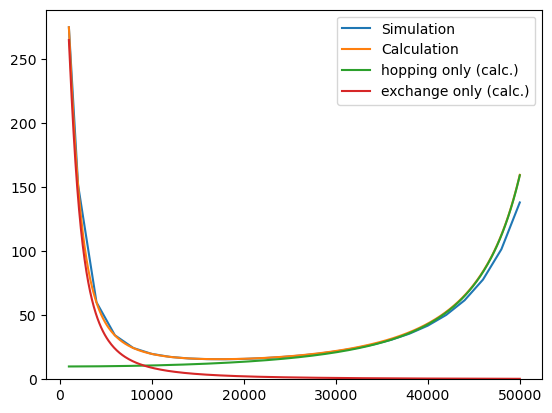

In [24]:
ax=plt.subplots()[1]
ax.plot(v10,R1p,label='Simulation')
v1,r1ph=R1p_hop(U)
v1,r1pe=R1p_ex(U)
ax.plot(v1,r1ph+r1pe,label='Calculation')
ax.plot(v1,r1ph,label='hopping only (calc.)')
ax.plot(v1,r1pe,label='exchange only (calc.)')
ax.legend()
_=ax.set_ylim([0,ax.get_ylim()[1]])


Note that for the hopping motion, the formulas do not exactly reproduce the expected rate constants near the rotary resonance condition. This may be because where there is significant oscillation, there is on average a higher effective field and therefore we have a slower decay rate.

### Extracting average decay rates with SLEEPY

Below, we plot an $R_{1\rho}$ decay curve, and the corresponding calculated multiexponential decay. The multiexponential decay results from extracting all real eigenvalues from the propagator and determining their weighting according to the initial density matrix and detection operator. In the nested for-loop, we see the decay curve and the average relaxation rate constant are being summed over all decaying components.

This process is how SLEEPY determines averaged decay rate constants. The `rho.extract_decay_rates` function has a number of averaging modes.

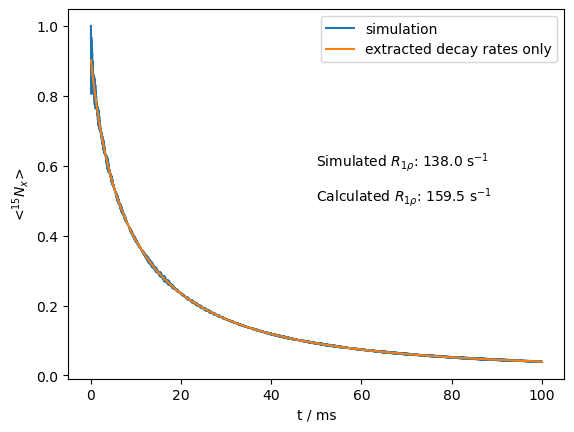

In [21]:
v1=50000
tc=1e-4
U=R1pU(tc=tc,v1=v1,gamma=0)
ax=sl.Rho('15Nx','15Nx').DetProp(U,n=6000).plot(label='simulation')
rates0,wts0=sl.Rho('15Nx','15Nx').extract_decay_rates(U,mode='rates')
t=np.linspace(0,0.1,500)
I=np.zeros(t.shape)
R0=0
wt_sum=0
for rates,wts,pwd_wt in zip(rates0,wts0,U.expsys.pwdavg.weight):
    for rate,wt in zip(rates,wts):
        I+=np.exp(-t*rate)*wt*pwd_wt
        R0+=rate*wt*pwd_wt
        wt_sum+=wt*pwd_wt
R0/=wt_sum

ax.text(50,0.6,fr'Simulated $R_{{1\rho}}$: {R0:.1f} s$^{{-1}}$')
ax.text(50,0.5,fr'Calculated $R_{{1\rho}}$: {R1p_hop(U,v1=v1)[1]+R1p_ex(U,v1=v1)[1]:.1f} s$^{{-1}}$')

ax.plot(t*1000,I,label='extracted decay rates only')
_=ax.legend()